In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#create class for wrapper object "Value", 
# it allows us to neatly print values and combinations of values


class Value:
    def __init__(self, data, _children=(), _op='', label='', ):
        self.data = data
        self.grad = 0.0 # 0 assumes weight does not affect loss function
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    # def below allows us to return string representation of obj
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self,other), '+')
        
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        return out
    
    def __mul__(self,other):
        other = other if isinstance(other, Value) else Value(other) 
        out = Value(self.data * other.data, (self,other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad  
        out._backward = _backward
        return out
    
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers"
        out = Value(self.data**other, (self,), f'**{other}') # supports signed powers
        
        def _backward():
            self.grad += (other * self.data ** (other-1)) * out.grad
        out._backward = _backward
        return out
    

    # allow rvalues to be treated as Value objects using rmul and radd
    
    def __radd__(self,other): # other + self
        return self + other;
    
    def __sub__(self, other): # self - other
        return self + (-other)
    
    def __rsub__(self, other): # other - self
        return other + (-self)
    
    
    # e.g., for 2 * a where a is Value object
    def __rmul__(self, other): # other * self
        return self * other;
    
    
    # define division operation as using negative exponents
    def __truediv__(self, other): # self/other
        return self * other**-1
    
    def __rtruediv__(self, other): # other / self
        return other * self**-1
    
    def __neg__(self): # -self
        return self * -1
    
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad  += (1-t**2) * out.grad
    
        out._backward = _backward
        
        return out
    
    
    def exp(self): # takes in a single scalar value and outputs a single scalar value
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad # because derivative of e**x = e**x
            
        out._backward = _backward
        
        return out
    
    
    def backward(self):
        # build topological graph for nodes in neuron
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0 # base case, initialize to 1
        # implement backpropogation using a loop by iterating through topo in reverse order
        for node in reversed(topo):
            node._backward()

In [3]:
a = Value(1.0)
b = Value(2.0)
b**-1

Value(data=0.5)

In [4]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [5]:
# 2 inputs (x1, x2) for 2D neuron
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

#bias of neuron
b = Value(6.8813735870195432, label='b')

# multiply inputs and weights, sum their products and add bias to sum
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'

# n is the cell body without the activation function (for now)
n = x1w1x2w2 + b; n.label = 'n'

# add activation function

# o = output
o = n.tanh(); o.label = 'o'



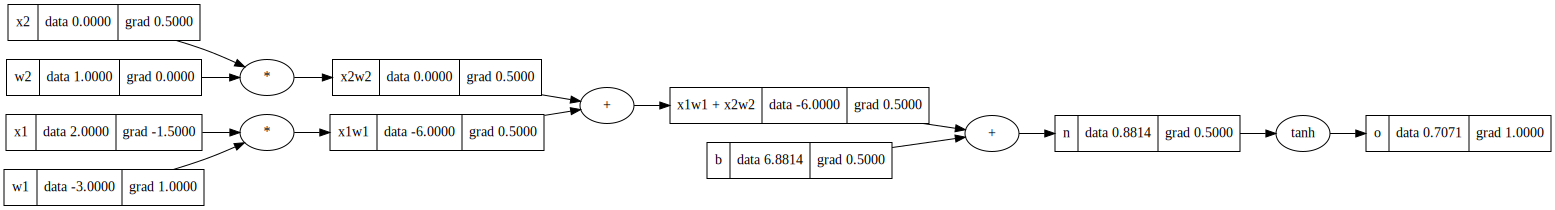

In [6]:
o.backward()
draw_dot(o)

In [7]:
# 2 inputs (x1, x2) for 2D neuron
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

#bias of neuron
b = Value(6.8813735870195432, label='b')

# multiply inputs and weights, sum their products and add bias to sum
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'

# n is the cell body without the activation function (for now)
n = x1w1x2w2 + b; n.label = 'n'




# add activation function

# o = output
e = (2*n).exp(); e.label = 'e'
o = (e-1) / (e+1)
o.label = 'o'

o.backward()

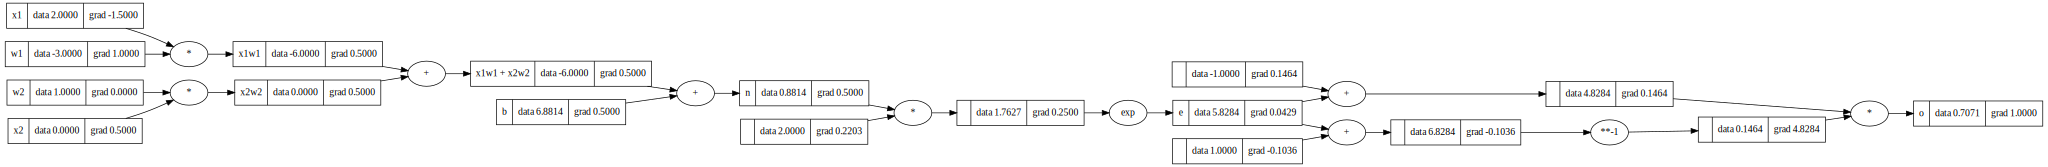

In [8]:
draw_dot(o)

In [9]:
# pytorch version of what we did above with Micrograd

# note leaf node gradients are set to false for efficiency reasons

import torch

x1 = torch.Tensor([2.0]).double();   x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('----')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
----
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [10]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [11]:
o.item()

0.7071066904050358

In [12]:
x1.grad

tensor([-1.5000], dtype=torch.float64)

In [13]:
class Neuron:
    # Constructor
    def __init__(self, num_inputs):
        self.w = [Value(random.uniform(-1,1)) for _ in range(num_inputs)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self,x):
        # w * x + b      <--- uses dot product
        activation_function = sum((wi*xi for wi, xi in zip(self.w,x)), self.b)
        out = activation_function.tanh()
        return out
    
    
# think of a layer (of a perceptron) as a collection/list of neurons
class Layer:
    def __init__(self, num_inputs, num_outputs):
        self.neurons = [Neuron(num_inputs) for _ in range(num_outputs)]
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    
# multi-layer perceptron
# instead of taking a single num_outputs like a Layer
# an MLP takes a list of num_outputs
# and this list defines the sizes of all the layers in our MLP
class MLP: # multi-layer perceptron
    def __init__(self, num_inputs, num_outputs):
        sz = [num_inputs] + num_outputs
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(num_outputs))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
        
x = [2.0, 3.0, -1.0]
n = MLP(2, [4,4,1]) # Makes 3 inputs into 2 layers of 4 and one output
n(x)

Value(data=-0.9622378475271851)

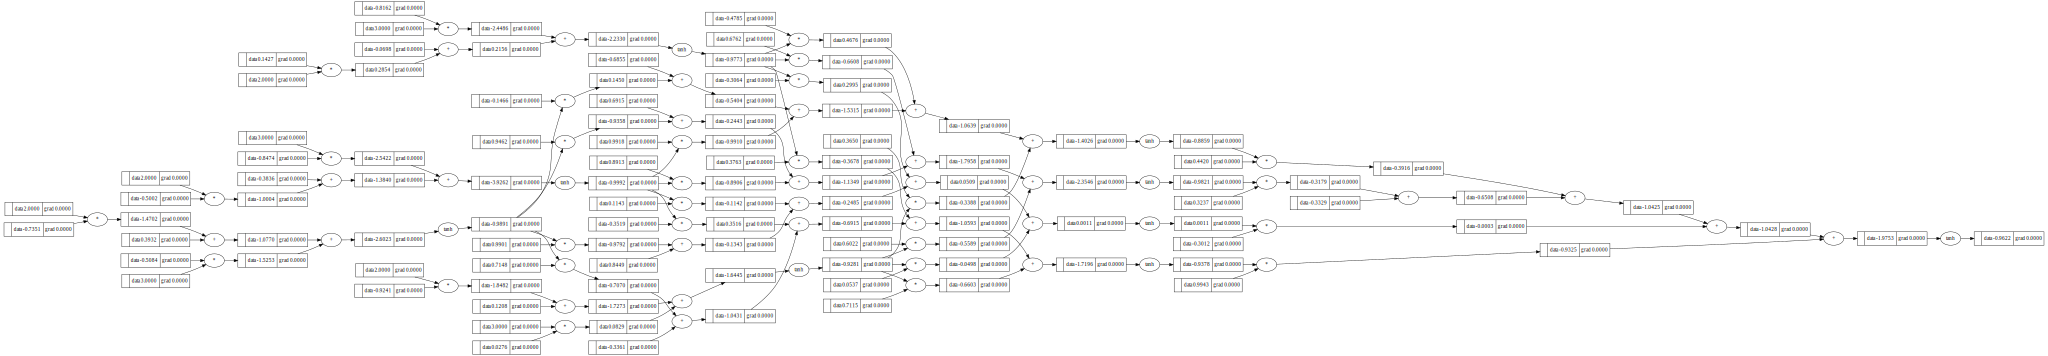

In [14]:
draw_dot(n(x))

In [15]:
# next step, use Micrograd for backprop to calculate gradients at all nodes in perceptron

In [16]:
xs = [
[2.0,3.0,-1.0],
[3.0,-1.0,0.5],
[0.5,1.0,1.0],
[1.0,1.0,-1.0],
]

ys = [1.0,-1.0,-1.0,1.0] # desired targets

ypred = [n(x) for x in xs]
ypred


[Value(data=-0.9622378475271851),
 Value(data=-0.9297956944492597),
 Value(data=-0.944970106744777),
 Value(data=-0.9579039634056836)]

In [17]:
# we need to tune weights to make ypred = ys (desired targets)
# number that measures performance of entire NN is called loss

In [22]:
# mean squared error loss function
# ygt = y ground truth 
# if yout/ypred = ygt/ys (desired output), then for each of the 4 you should get a 0 here
[(yout-ygt)**2 for ygt, yout in zip(ys,ypred)] 

[Value(data=3.8503773702681205),
 Value(data=0.004928644517861707),
 Value(data=0.0030282891516812383),
 Value(data=3.8333879299196845)]

In [23]:
total_loss = sum((yout-ygt)**2 for ygt, yout in zip(ys,ypred))
total_loss

Value(data=7.691722233857348)